# Detectron2

In [ ]:
#%pip install roboflow
#from roboflow import Roboflow
#rf = Roboflow(api_key="")
#project = rf.workspace("aerial-person-detection").project("aerial-person-detection")
#version = project.version(3)
#dataset = version.download("yolov11")

In [2]:
%pip install 'git+https://github.com/facebookresearch/detectron2.git'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-vmy6_7bj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-vmy6_7bj
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [19]:
import os
import cv2
import json
from PIL import Image
import torch
from matplotlib import pyplot as plt
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
print(detectron2.__version__)

0.6


## Преобразуем датасет с формата YOLO в COCO JSON для использования Detectron2

In [4]:
def create_annotation(images_dir, labels_dir, annotation_json_name):
    # Создаем структуру COCO
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Добавляем категории
    classes = ['bicycle', 'bus', 'car', 'motorcycle', 'person', 'truck']
    for i, class_name in enumerate(classes):
        coco_data["categories"].append({
            "id": i + 1,
            "name": class_name
        })
    # Обрабатываем изображения и аннотации
    annotation_id = 1
    for image_id, image_name in enumerate(os.listdir(images_dir)):
        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(labels_dir, image_name.replace(".jpg", ".txt"))

        # Открываем изображение для получения размеров
        with Image.open(image_path) as img:
            width, height = img.size

        # Добавляем изображение в COCO
        coco_data["images"].append({
            "id": image_id + 1,
            "file_name": image_name,
            "width": width,
            "height": height
        })

        # Читаем аннотации
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()
                for line in lines:
                    class_id, x_center, y_center, w, h = map(float, line.strip().split())

                    # Преобразуем координаты YOLO в COCO
                    x_min = (x_center - w / 2) * width
                    y_min = (y_center - h / 2) * height
                    bbox_width = w * width
                    bbox_height = h * height

                    # Добавляем аннотацию
                    coco_data["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id + 1,
                        "category_id": int(class_id) + 1,
                        "bbox": [x_min, y_min, bbox_width, bbox_height],
                        "area": bbox_width * bbox_height,
                        "iscrowd": 0
                    })
                    annotation_id += 1

    # Сохраняем COCO JSON
    with open(annotation_json_name, "w") as f:
        json.dump(coco_data, f, indent=4)

In [5]:
create_annotation(images_dir='/home/jupyter/datasphere/project/Aerial-Person-Detection-3/train/images', 
                  labels_dir='/home/jupyter/datasphere/project/Aerial-Person-Detection-3/train/labels', 
                  annotation_json_name='data_train.json')

In [6]:
create_annotation(images_dir='/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/images', 
                  labels_dir='/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/labels', 
                  annotation_json_name='data_valid.json')

## Обучение Detectron2

In [7]:
register_coco_instances("my_dataset_train", 
                        {}, 
                        "/home/jupyter/datasphere/project/data_train.json", 
                        "/home/jupyter/datasphere/project/Aerial-Person-Detection-3/train/images")
register_coco_instances("my_dataset_val", 
                        {}, 
                        "/home/jupyter/datasphere/project/data_valid.json", 
                        "/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/images")

In [48]:
cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Предобученные веса
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Предобученные веса
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  
cfg.OUTPUT_DIR = "/home/jupyter/datasphere/project/output"

In [49]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/14 12:17:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[03/14 12:17:08 d2.engine.train_loop]: Starting training from iteration 0
[03/14 12:17:23 d2.utils.events]:  eta: 0:38:12  iter: 19  total_loss: 3.474  loss_cls: 1.951  loss_box_reg: 0.6798  loss_rpn_cls: 0.6414  loss_rpn_loc: 0.2853    time: 0.7549  last_time: 0.7675  data_time: 0.0192  last_data_time: 0.0058   lr: 4.9953e-06  max_mem: 9574M
[03/14 12:17:38 d2.utils.events]:  eta: 0:37:42  iter: 39  total_loss: 3.403  loss_cls: 1.892  loss_box_reg: 0.6703  loss_rpn_cls: 0.419  loss_rpn_loc: 0.3582    time: 0.7448  last_time: 0.8261  data_time: 0.0061  last_data_time: 0.0060   lr: 9.9902e-06  max_mem: 9574M
[03/14 12:17:53 d2.utils.events]:  eta: 0:37:34  iter: 59  total_loss: 3.022  loss_cls: 1.742  loss_box_reg: 0.6493  loss_rpn_cls: 0.2738  loss_rpn_loc: 0.3266    time: 0.7447  last_time: 0.7202  data_time: 0.0060  last_data_time: 0.0062   lr: 1.4985e-05  max_mem: 9574M
[03/14 12:18:08 d2.utils.events]:  eta: 0:37:19  iter: 79  total_loss: 2.634  loss_cls: 1.541  loss_box_reg: 0.571

## Проверка метрики качества модели

### С помощью встроенных методов 

Создадим предиктор для только что обученной модели

In [50]:
predictor_cfg = cfg.clone()
predictor_cfg.MODEL.WEIGHTS = '/home/jupyter/datasphere/project/output/model_final.pth'
predictor_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor_cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(predictor_cfg)

[03/14 12:55:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jupyter/datasphere/project/output/model_final.pth ...


Оценим производительность модели используя AP метрику, реализованную в COCO API.

In [51]:
# Создадим evaluator
evaluator = COCOEvaluator("my_dataset_val", output_dir="/home/jupyter/datasphere/project/output")
# Загрузим данные для тестирования
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
# Запустим оценку
results = inference_on_dataset(predictor.model, val_loader, evaluator)
# Выведем результаты
print(results)

[03/14 12:55:22 d2.data.datasets.coco]: Loaded 545 images in COCO format from /home/jupyter/datasphere/project/data_valid.json
[03/14 12:55:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/14 12:55:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/14 12:55:23 d2.data.common]: Serializing 545 elements to byte tensors and concatenating them all ...
[03/14 12:55:23 d2.data.common]: Serialized dataset takes 2.20 MiB
[03/14 12:55:23 d2.evaluation.evaluator]: Start inference on 545 batches
[03/14 12:55:24 d2.evaluation.evaluator]: Inference done 11/545. Dataloading: 0.0020 s/iter. Inference: 0.1151 s/iter. Eval: 0.0005 s/iter. Total: 0.1177 s/iter. ETA=0:01:02
[03/14 12:55:29 d2.evaluation.evaluator]: Inference done 54/545. Dataloading: 0.0020 s/iter. Inference: 0.1147 s/iter. Eval: 0.0004 s/iter. Total: 0.1172 s/i

'AP50': 26.409935731160594, 'AP75': 17.72445909064475

### Визуализируем результаты предсказаний

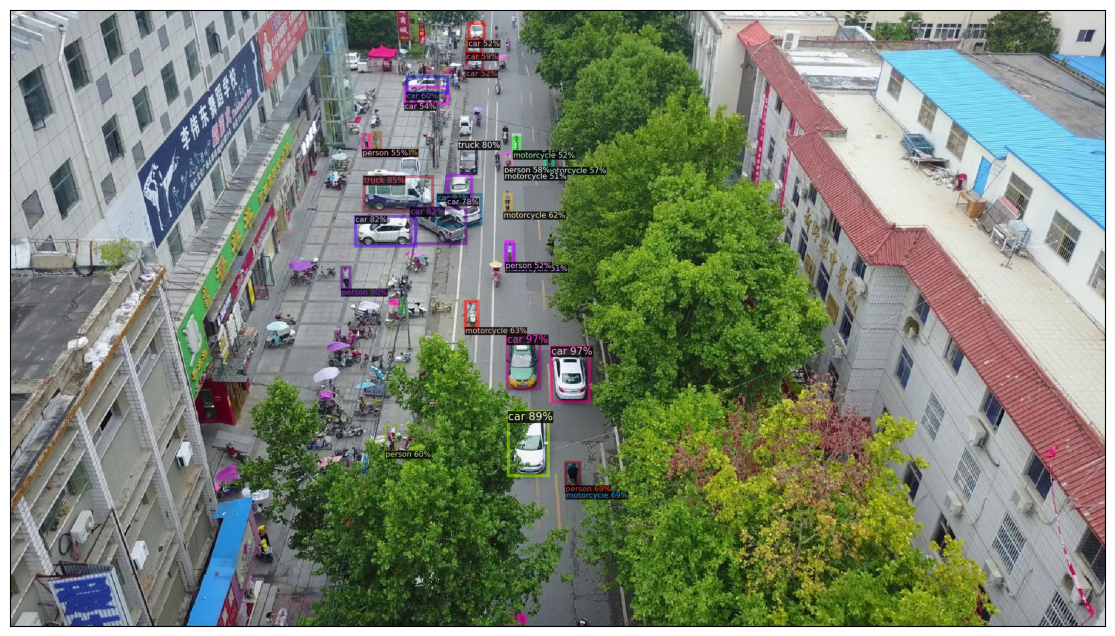

In [52]:
# Загрузим изображение
im = cv2.imread("/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/images/0000001_02999_d_0000005_jpg.rf.50147156d1b6441a394d4dde52603c9d.jpg")
# Сделаем предсказание
outputs = predictor(im)
# Визуализируйте результат
v = Visualizer(im[:, :, ::-1], 
               MetadataCatalog.get("my_dataset_val"), 
               scale=1.2
              )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(16,8))
plt.xticks([]),plt.yticks([])
plt.imshow(out.get_image())
plt.show()

### Реализуем вручную вычисление метрики IoU

In [87]:
def compute_iou(box1, box2):
    """
    Вычисляет IoU между двумя bounding box'ами.
    box1 и box2 должны быть в формате [x_min, y_min, x_max, y_max].
    """
    # Определяем координаты пересечения
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Вычисляем площадь пересечения
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Вычисляем площади каждого bounding box'а
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Вычисляем площадь объединения
    union_area = box1_area + box2_area - intersection_area

    # Вычисляем IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

In [88]:
def get_iou_scores(dataset_dicts, predictor):
    iou_scores = []
    for item in dataset_dicts:
        image = cv2.imread(item['file_name'])
        outputs = predictor(image)

        #Предсказанный bbox
        pred_boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()

        #Размеченный bbox
        gt_boxes = [anno['bbox'] for anno in item['annotations']]

        # Вычисление IoU для каждой пары предсказанного и истинного bbox
        for gt_box in gt_boxes:
            for pred_box in pred_boxes:
                iou_score = compute_iou(gt_box, pred_box)
                iou_scores.append(iou_score)

    return iou_scores

In [89]:
predictor = DefaultPredictor(predictor_cfg)
test_dataset = DatasetCatalog.get('my_dataset_val')

iou_scores = get_iou_scores(test_dataset, predictor)
average_iou = sum(iou_scores) / len(iou_scores)
print(f'Среднее IoU: {average_iou}')

[03/14 13:51:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jupyter/datasphere/project/output/model_final.pth ...
[03/14 13:51:48 d2.data.datasets.coco]: Loaded 545 images in COCO format from /home/jupyter/datasphere/project/data_valid.json
Среднее IoU: 7.570077940282456e-06
